# Imports


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Process Price Data


## Load Price Data & Data Cleaning


In [59]:
prices = pd.read_csv(
    "../../data/prices.csv",
    parse_dates=["date"],
    na_values={  # to make sure that RET and RETX can be correctly casted to float
        "ret": ["B", "C"],
        "retx": ["B", "C"],
    },
    dtype={
        "ret": np.float64,
        "retx": np.float64,
    },  # forces the casting of RET and RETX to float
)


prices: pd.DataFrame

In [61]:
prices.head()

,permno,date,nameendt,shrcd,exchcd,siccd,ticker,comnam,tsymbol,naics,...,cfacpr,cfacshr,openprc,numtrd,retx,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10078,2000-01-03,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,0.5,0.5,79.2500,26427.0,-0.012107,-0.006803,-0.006810,0.002878,0.002860,-0.009549
1,10078,2000-01-04,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,0.5,0.5,73.4375,32108.0,-0.062092,-0.039652,-0.039679,-0.017465,-0.017486,-0.038345
2,10078,2000-01-05,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,0.5,0.5,70.1250,49741.0,0.001742,-0.000935,-0.001009,0.007821,0.007743,0.001922
3,10078,2000-01-06,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,0.5,0.5,70.4375,30663.0,-0.053913,-0.007391,-0.007547,0.004504,0.004453,0.000956
4,10078,2000-01-07,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,0.5,0.5,67.1875,34162.0,0.056985,0.032516,0.032514,0.017008,0.016991,0.027090


In [62]:
# there are some duplicate dates for the same permno, here I remove them from the df
prices = prices.drop_duplicates(subset=["permno", "date"])

# checking that there are no duplicates left
for permno in prices["permno"].unique():
    dates = prices[prices["permno"] == permno]["date"]

    if dates.shape[0] != dates.nunique():
        print(permno)
        print(dates)
        # prices[prices["permno"] == permno].to_excel('debug.xlsx')
        print(dates[dates.duplicated()])
        break

In [69]:
prices.dropna(subset=["ret"], inplace=True)

In [72]:
prices.isna().sum() / prices.shape[0]

permno         0.000000
date           0.000000
nameendt       0.999118
shrcd          0.000000
exchcd         0.000000
                 ...   
vol_252d       0.024612
vol_126d       0.012289
vol_21d        0.001969
ret_vol_adj    0.024612
mktcap         0.000000
Length: 61, dtype: float64

## Compute Volatility of Returns, Market Cap, and Vol-Adjusted Returns


In [73]:
# calculating vols
# use the ret column from WRDS



prices.sort_values(["permno", "date"], inplace=True)



prices["vol_36mo"] = prices["ret"].rolling(window=252 * 3).std()



prices["vol_252d"] = prices["ret"].rolling(window=252).std()



prices["vol_126d"] = prices["ret"].rolling(window=126).std()



prices["vol_21d"] = prices["ret"].rolling(window=21).std()

In [74]:
# calculate volatility-adjusted returns
VOLATILITY_WINDOW = 252
prices["ret_vol_adj"] = prices["ret"] / prices[f"vol_{VOLATILITY_WINDOW}d"]

In [75]:
prices["mktcap"] = prices["prc"].abs() * prices["shrout"]

In [76]:
prices.tail()

,permno,date,nameendt,shrcd,exchcd,siccd,ticker,comnam,tsymbol,naics,...,vwretx,ewretd,ewretx,sprtrn,vol_36mo,vol_252d,vol_126d,vol_21d,ret_vol_adj,mktcap
3892525,93436,2023-12-22,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.002372,0.007676,0.007387,0.001660,0.037037,0.035495,0.030185,0.020859,-0.216962,8.028047e+08
3892526,93436,2023-12-26,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.005199,0.009674,0.009299,0.004232,0.037036,0.035025,0.030031,0.021031,0.460128,8.157429e+08
3892527,93436,2023-12-27,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.001807,0.005276,0.004907,0.001430,0.037041,0.035013,0.030002,0.021262,0.537571,8.310971e+08
3892528,93436,2023-12-28,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,-0.000295,0.002042,0.001428,0.000370,0.037050,0.034286,0.030136,0.020625,-0.921474,8.048392e+08
3892529,93436,2023-12-29,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,-0.004084,-0.007480,-0.007546,-0.002826,0.037057,0.034266,0.030147,0.020932,-0.541765,7.898983e+08


In [84]:
prices[["prc", "mktcap"]].isna().sum() / prices.shape[0]

prc       0.0
mktcap    0.0
dtype: float64

## Adjust Price for Stock Splits and Dividends


In [108]:
prices["prc_adj"] = prices["prc"] / prices["cfacpr"]

prices[["prc", "prc_adj"]].isna().sum()

prc        0
prc_adj    0
dtype: int64

Below are some sanity checks for stock prices


In [119]:
def plot_prices(permno):
    mask = prices["permno"] == permno
    data = prices[mask][["date", "prc", "prc_adj"]]

    fig, ax = plt.subplots()
    ax.set_title(f"Permno {permno}")

    ax.plot(data["date"], data["prc"], label="prc")
    ax2 = ax.twinx()
    ax2.plot(data["date"], data["prc_adj"], label="prc_adj", color="red")

    fig.legend()

    plt.show()

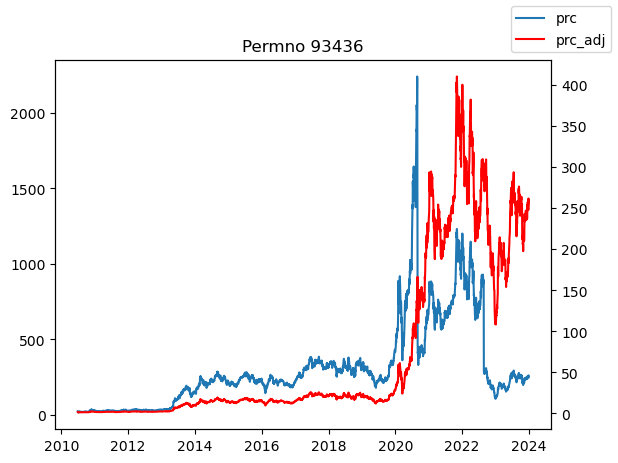

In [120]:
plot_prices(93436)

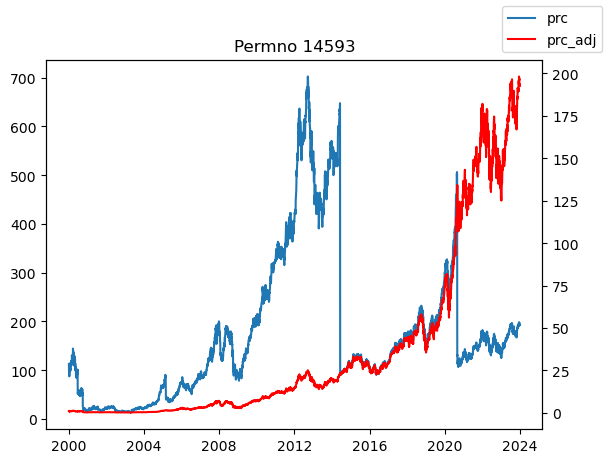

In [121]:
plot_prices(14593)

## Calculating Industry Specific Returns


In [80]:
prices.head()

,permno,date,nameendt,shrcd,exchcd,siccd,ticker,comnam,tsymbol,naics,...,vwretx,ewretd,ewretx,sprtrn,vol_36mo,vol_252d,vol_126d,vol_21d,ret_vol_adj,mktcap
0,10078,2000-01-03,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,-0.006810,0.002878,0.002860,-0.009549,NaN,NaN,NaN,NaN,NaN,1.194246e+08
1,10078,2000-01-04,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,-0.039679,-0.017465,-0.017486,-0.038345,NaN,NaN,NaN,NaN,NaN,1.120094e+08
2,10078,2000-01-05,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,-0.001009,0.007821,0.007743,0.001922,NaN,NaN,NaN,NaN,NaN,1.122045e+08
3,10078,2000-01-06,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,-0.007547,0.004504,0.004453,0.000956,NaN,NaN,NaN,NaN,NaN,1.061552e+08
4,10078,2000-01-07,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,0.032514,0.017008,0.016991,0.027090,NaN,NaN,NaN,NaN,NaN,1.122045e+08


In [81]:
# define the part of the code to use - in this case 2 digits
DIGITS = 2

prices["naics"] = prices["naics"].replace(0, np.nan)  # replace 0s with NaNs
prices["naics_processed"] = prices["naics"]

mask = prices["naics_processed"].notna()
prices.loc[mask, "naics_processed"] = prices.loc[mask, "naics_processed"].apply(
    lambda x: float(str(x)[:DIGITS])
)
prices["naics_processed"].unique()

array([nan, 33., 51., 54., 22., 52., 42., 31., 32., 56., 44., 72., 62.,
       45., 55., 48., 21., 53., 81., 11., 23., 71., 61., 49., 92.])

In [82]:
# calculate industry returns

USE_VOL_ADJUSTED_RETURNS = True

return_col = (
    "ret_vol_adj" if USE_VOL_ADJUSTED_RETURNS else "ret"
)  # choose whether to use vol adjusted returns or not

# create df with dates as index and industry codes as columns
industry_returns_df = pd.DataFrame(
    columns=prices["naics_processed"].unique(), index=prices.date.unique()
)

# do not calculate mean when the code is NaN
# industry_returns_df.drop(np.nan, axis=1, inplace=True)

# for each industry code calculate the average industry return at each date
for industry_code in industry_returns_df.columns:
    if industry_code == np.nan:
        continue
    # print(f'calculating for industry code {industry_code}')

    # filter companies in the industry
    companies = prices[prices["naics_processed"] == industry_code]

    # groupby the date and calculate the weighted average return (market-cap weighted)
    industry_return = companies.groupby("date").apply(
        lambda x: np.average(x[return_col], weights=x["mktcap"])  # type: ignore
    )
    industry_returns_df.loc[industry_return.index, industry_code] = industry_return

C:\Users\andre\AppData\Local\Temp\ipykernel_14164\3319798696.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  industry_return = companies.groupby("date").apply(
C:\Users\andre\AppData\Local\Temp\ipykernel_14164\3319798696.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  industry_return = companies.groupby("date").apply(
C:\Users\andre\AppData\Local\Temp\ipykernel_14164\3319798696.py:27: DeprecationW

In [85]:
industry_returns_df.tail()

,NaN,33.0,51.0,54.0,22.0,52.0,42.0,31.0,32.0,56.0,...,48.0,21.0,53.0,81.0,11.0,23.0,71.0,61.0,49.0,92.0
2023-12-22,NaN,0.003517,0.09182,0.360505,0.301421,0.187276,0.309151,-0.175943,0.454168,0.049737,...,0.292156,0.261953,0.073162,NaN,0.224817,0.048115,-0.197597,0.659214,0.325504,0.599059
2023-12-26,NaN,0.315202,0.047947,0.079602,0.478285,0.264515,0.276708,0.411157,0.179407,0.215441,...,0.254757,0.52899,0.50018,NaN,0.711048,0.303093,0.274185,0.298851,0.382908,0.154162
2023-12-27,NaN,0.106531,0.00378,-0.271988,-0.070654,0.216891,0.014885,0.1972,0.267019,0.064521,...,0.05911,-0.178255,0.263745,NaN,-0.026075,0.335978,-0.212695,0.100039,-0.209094,-0.045533
2023-12-28,NaN,0.008914,0.158247,-0.034354,0.460763,0.238347,-0.189551,0.278819,-0.114407,0.343019,...,0.012973,-0.639762,0.292929,NaN,0.14343,-0.047683,0.562516,-0.297754,0.346279,0.068415
2023-12-29,NaN,-0.221914,-0.030868,-0.169646,-0.065779,-0.090783,0.143961,0.182055,0.021168,-0.060917,...,-0.46174,-0.189679,-0.631729,NaN,-0.22168,-0.048535,-0.306915,-0.154685,-0.19209,0.171194


In [91]:
# see how many NaN values are there in the industry returns
mask = industry_returns_df.index.year > 2004  # type: ignore


industry_returns_df[mask].T.isna().sum()[industry_returns_df.T.isna().sum() > 4]

Series([], dtype: int64)

In [97]:
# calculate industry-relative returns

# map each datapoint to its industry return
for industry_code in industry_returns_df.columns.drop(np.nan):

    # create mask for the companies belonging to the industry
    mask = prices["naics_processed"] == industry_code

    # map the industry return to the companies at each date
    prices.loc[mask, "ret_industry_tot"] = prices.loc[mask, "date"].map(
        industry_returns_df[industry_code]
    )

    # DEBUG code: the industry return for a specific date should be the same for all companies belonging to the same industry
    # print(prices.loc[mask, ['date', 'naics_processed', 'ticker', 'industry_return']].sort_values('date'))

prices["ret_industry_relative"] = (
    prices[return_col] - prices["ret_industry_tot"]
).astype(
    "float64"
)  # from above, use vol adjusted if USE_VOL_ADJUSTED_RETURNS is True

prices

,permno,date,nameendt,shrcd,exchcd,siccd,ticker,comnam,tsymbol,naics,...,vol_252d,vol_126d,vol_21d,ret_vol_adj,mktcap,naics_processed,industry_return,industry_relative_return,ret_industry_tot,ret_industry_relative
0,10078,2000-01-03,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,NaN,1.194246e+08,NaN,NaN,NaN,NaN,NaN
1,10078,2000-01-04,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,NaN,1.120094e+08,NaN,NaN,NaN,NaN,NaN
2,10078,2000-01-05,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,NaN,1.122045e+08,NaN,NaN,NaN,NaN,NaN
3,10078,2000-01-06,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,NaN,1.061552e+08,NaN,NaN,NaN,NaN,NaN
4,10078,2000-01-07,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,NaN,1.122045e+08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3892525,93436,2023-12-22,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.035495,0.030185,0.020859,-0.216962,8.028047e+08,33.0,0.003517,-0.220480,0.003517,-0.220480
3892526,93436,2023-12-26,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.035025,0.030031,0.021031,0.460128,8.157429e+08,33.0,0.315202,0.144926,0.315202,0.144926
3892527,93436,2023-12-27,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.035013,0.030002,0.021262,0.537571,8.310971e+08,33.0,0.106531,0.431040,0.106531,0.431040
3892528,93436,2023-12-28,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.034286,0.030136,0.020625,-0.921474,8.048392e+08,33.0,0.008914,-0.930388,0.008914,-0.930388


In [98]:
prices[
    ["ret_industry_relative", "ret_industry_tot", "naics_processed"]
].isna().sum() / prices.shape[0]

ret_industry_relative    0.170452
ret_industry_tot         0.170452
naics_processed          0.170452
dtype: float64

In [107]:
# see how many NaN values are there in the industry returns
mask = prices.set_index("date").index.year >= 2005  # type: ignore
prices.loc[mask, ["ret_industry_tot", "ret_industry_relative"]].isna().sum() / prices[
    mask
].shape[0]

ret_industry_tot         0.001923
ret_industry_relative    0.001923
dtype: float64

$\Rightarrow$ **We have reliable data for industry returns starting from 2005**


# Fama-French Residual Returns (TOFIX)


In [122]:
ff_data = pd.read_csv(
    "../../data/fama_french_5_factors.csv", parse_dates=["date"], date_format="%Y%m%d"
)

ff_data = ff_data.set_index("date").reindex(prices.date.unique())
ff_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2000-01-03,-0.71,-0.06,-1.41,-1.50,-0.64,0.021
2000-01-04,-4.06,0.33,2.06,0.47,1.45,0.021
2000-01-05,-0.09,0.33,0.16,0.41,1.11,0.021
2000-01-06,-0.73,-0.04,1.26,0.65,1.21,0.021
2000-01-07,3.21,-0.94,-1.42,-0.88,-0.96,0.021
...,...,...,...,...,...,...
2023-12-22,0.21,0.61,0.09,-0.64,0.19,0.021
2023-12-26,0.48,0.81,0.46,-0.34,-0.15,0.021
2023-12-27,0.16,0.16,0.12,-0.31,-0.14,0.021


In [18]:
REGRESSION_WINDOW = 1 * 252  # in the paper 36months
MIN_OBS = 126


prices_filtered = prices[["permno", "date", "ticker", "return", "vol_36mo"]]


# prices_filtered.loc[:, "return"] *= 100  # convert to percentage


def perform_rolling_ols(permno):

    stock_data = prices_filtered[prices_filtered["permno"] == permno]

    if stock_data.shape[0] < REGRESSION_WINDOW:
        print("returning all NaNs")
        return None

    # print(stock_data)

    ff_factors = ff_data.reindex(stock_data["date"])

    data = stock_data.merge(ff_factors, left_on="date", right_index=True)

    endog = data["return"] - data["RF"]

    exog = sm.add_constant(data[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]])

    rolling_ols = RollingOLS(
        endog, exog, window=REGRESSION_WINDOW, min_nobs=MIN_OBS, expanding=True
    )

    rres = rolling_ols.fit(params_only=True)

    # calculate pred values by multiplying the exog matrix with the params matrix

    # the correct predictions (the ones calculated using the factors and params at the same date) lie on the diagonal of the matrix

    # to get e we do y - the diagonal of the pred matrix

    pred: np.ndarray = (exog @ rres.params.T).to_numpy()

    e = endog - pred.diagonal()

    scaled_e = e / data["vol_36mo"]  # scale by volatility

    scaled_e.index = data["date"]

    return scaled_e

    # scale by volatility


prices["str_paper_residuals"] = np.nan


for permno in prices["permno"].unique():
    print(f"Regressing Permno {permno}")

    # print(prices.loc[mask, "str_paper_residuals"])

    scaled_e = perform_rolling_ols(permno)
    if scaled_e is None:
        continue

    # print("scaled_e")

    # print(scaled_e)

    mask = (prices["permno"] == permno) & (prices["date"].isin(scaled_e.index))

    # print(prices[mask].shape, scaled_e.shape)

    masked = prices[mask]

    # print(masked["date"].shape, masked["date"].nunique())

    prices.loc[mask, "str_paper_residuals"] = scaled_e

    # find out how to merge correctly in the main dataframe efficiently

    # prices.loc[mask, "str_paper_residuals"] = scaled_e

Regressing Permno 10078
Regressing Permno 10104
Regressing Permno 10107
Regressing Permno 10137
Regressing Permno 10138
Regressing Permno 10145
Regressing Permno 10147
Regressing Permno 10225
Regressing Permno 10299
Regressing Permno 10324
Regressing Permno 10516
Regressing Permno 10696
Regressing Permno 10909
Regressing Permno 11081
Regressing Permno 11308
Regressing Permno 11403
Regressing Permno 11404
Regressing Permno 11533
Regressing Permno 11552
Regressing Permno 11600
Regressing Permno 11618
Regressing Permno 11674
Regressing Permno 11703
Regressing Permno 11754
Regressing Permno 11762
Regressing Permno 11786
Regressing Permno 11850
Regressing Permno 11891
Regressing Permno 11896
Regressing Permno 11955
Regressing Permno 11976
Regressing Permno 12052
Regressing Permno 12060
Regressing Permno 12062
Regressing Permno 12067
Regressing Permno 12073
Regressing Permno 12076
Regressing Permno 12084
Regressing Permno 12140
Regressing Permno 12308
Regressing Permno 12345
Regressing Permn

KeyboardInterrupt: 

In [ ]:
prices[prices["a"] == 12346]

,permno,ticker,permco,SICCD,NAICS,date,DlyCalDt,DlyPrc,DlyPrcFlg,DlyCap,...,DlyNumTrd,DlyPrcVol,ShrOut,return,vol_36mo,vol_252d,vol_126d,vol_21d,vol_adjusted_return,str_paper_residuals
203169,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-14,2010-10-14,27.07,TR,5868018.04,...,NaN,20085940.0,216772.0,NaN,0.032073,0.047258,0.064950,0.156372,NaN,NaN
203170,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-15,2010-10-15,26.66,TR,5779141.52,...,NaN,15884028.0,216772.0,-0.015146,0.032070,0.047264,0.064926,0.156192,-0.320451,NaN
203171,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-18,2010-10-18,26.75,TR,5798651.00,...,NaN,11890375.0,216772.0,0.003376,0.032070,0.047258,0.064930,0.156359,0.071435,NaN
203172,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-19,2010-10-19,26.46,TR,5735787.12,...,NaN,22451310.0,216772.0,-0.010841,0.032059,0.047234,0.064908,0.156378,-0.229519,NaN
203173,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-20,2010-10-20,27.09,TR,5872353.48,...,NaN,38351313.0,216772.0,0.023810,0.032046,0.047254,0.064951,0.156763,0.503859,NaN
203174,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-21,2010-10-21,27.58,TR,5978571.76,...,NaN,24173870.0,216772.0,0.018088,0.032004,0.047208,0.064975,0.157027,0.383150,NaN
203175,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-22,2010-10-22,27.54,TR,5969900.88,...,NaN,8143578.0,216772.0,-0.001450,0.032003,0.047197,0.064952,0.156966,-0.030729,NaN
203176,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-25,2010-10-25,27.95,TR,6058777.40,...,NaN,17871230.0,216772.0,0.014887,0.032007,0.047208,0.064977,0.157138,0.315356,NaN
203177,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-26,2010-10-26,27.73,TR,6011087.56,...,NaN,13787356.0,216772.0,-0.007871,0.032008,0.047201,0.064967,0.157163,-0.166760,NaN
203178,12346.0,LYB,53531.0,2821.0,325211.0,2010-10-27,2010-10-27,27.20,TR,5896198.40,...,NaN,2211360.0,216772.0,-0.019113,0.032003,0.047206,0.064978,0.156822,-0.404883,NaN


this still to be fixed


# Other Price Indicators


In [124]:
prices.sort_values(["permno", "date"], inplace=True)
prices.head()

,permno,date,nameendt,shrcd,exchcd,siccd,ticker,comnam,tsymbol,naics,...,vol_126d,vol_21d,ret_vol_adj,mktcap,naics_processed,industry_return,industry_relative_return,ret_industry_tot,ret_industry_relative,prc_adj
0,10078,2000-01-03,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,1.194246e+08,NaN,NaN,NaN,NaN,NaN,153.00
1,10078,2000-01-04,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,1.120094e+08,NaN,NaN,NaN,NaN,NaN,143.50
2,10078,2000-01-05,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,1.122045e+08,NaN,NaN,NaN,NaN,NaN,143.75
3,10078,2000-01-06,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,1.061552e+08,NaN,NaN,NaN,NaN,NaN,136.00
4,10078,2000-01-07,NaN,11,3,3570,SUNW,SUN MICROSYSTEMS INC,SUNW,NaN,...,NaN,NaN,NaN,1.122045e+08,NaN,NaN,NaN,NaN,NaN,143.75


In [125]:
def calculate_MACD(data: pd.DataFrame, price_col: str):
    # Calculate the 12-period EMA
    data["EMA12"] = data[price_col].ewm(span=12, adjust=False).mean()

    # Calculate the 26-period EMA
    data["EMA26"] = data[price_col].ewm(span=26, adjust=False).mean()

    # Calculate MACD (the difference between 12-period EMA and 26-period EMA)
    data["MACD"] = data["EMA12"] - data["EMA26"]

    # Calculate the 9-period EMA of MACD (Signal Line)
    data["MACD_index"] = data["MACD"].ewm(span=9, adjust=False).mean()
    # data.loc[data['MACD'].isna(), 'MACD_index'] = np.nan

    mask = data["permno"] != data["permno"].shift(1)
    data.loc[mask, ["MACD", "MACD_index"]] = np.nan

    data.drop(["EMA12", "EMA26", "MACD"], axis=1, inplace=True)


calculate_MACD(prices, "prc_adj")

In [126]:
prices.tail()

,permno,date,nameendt,shrcd,exchcd,siccd,ticker,comnam,tsymbol,naics,...,vol_21d,ret_vol_adj,mktcap,naics_processed,industry_return,industry_relative_return,ret_industry_tot,ret_industry_relative,prc_adj,MACD_index
3892525,93436,2023-12-22,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.020859,-0.216962,8.028047e+08,33.0,0.003517,-0.220480,0.003517,-0.220480,252.53999,4.421230
3892526,93436,2023-12-26,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.021031,0.460128,8.157429e+08,33.0,0.315202,0.144926,0.315202,0.144926,256.60999,4.636162
3892527,93436,2023-12-27,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.021262,0.537571,8.310971e+08,33.0,0.106531,0.431040,0.106531,0.431040,261.44000,4.915272
3892528,93436,2023-12-28,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.020625,-0.921474,8.048392e+08,33.0,0.008914,-0.930388,0.008914,-0.930388,253.17999,5.076989
3892529,93436,2023-12-29,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,0.020932,-0.541765,7.898983e+08,33.0,-0.221914,-0.319851,-0.221914,-0.319851,248.48000,5.070092


In [127]:
# RSI Index



def calculate_RSI(data: pd.DataFrame, price_col: str, window: int):

    change = data[price_col].diff()


    change_up, change_down = change.copy(), change.copy()


    change_up[change_up < 0] = 0

    change_down[change_down > 0] = 0


    # check we did not make mistakes

    assert change.equals(change_up + change_down)


    # calculate EWMAs

    avg_up = change_up.ewm(span=window, adjust=False).mean()

    avg_down = change_down.ewm(span=window, adjust=False).mean().abs()


    # calculate RSI

    rsi = 100 * avg_up / (avg_up + avg_down)

    data["rsi"] = rsi


    mask = data["permno"] != data["permno"].shift(1)

    data.loc[mask, "rsi"] = np.nan

In [128]:
calculate_RSI(prices, "prc_adj", 14)

# Indicator Feature for whether the stock is currently in the S&P500


In [165]:
constituents = pd.read_csv(
    "../../data/sp500_constituents_2010.csv",
    index_col=0,
    parse_dates=["from_date", "thru_date"],
)
constituents.head()

,from_date,thru_date
permno,,
26825,1961-04-26,2023-12-29
46877,1975-06-12,2018-01-02
24109,1951-09-06,2023-12-29
25320,1957-03-01,2023-12-29
70519,1988-05-26,2023-12-29


In [166]:
# check that the permnos in the two DataFrames are the same
print(set(prices["permno"].unique()) - set(constituents.index.unique()))
print(set(constituents.index.unique()) - set(prices["permno"].unique()))

set()
set()


In [170]:
prices["in_sp500"] = 0

permnos = prices["permno"].unique()


def set_in_sp500(permno, from_date, thru_date):
    mask = (
        (prices["permno"] == permno)
        & (prices["date"] >= from_date)
        & (prices["date"] <= thru_date)
    )
    prices.loc[mask, "in_sp500"] = 1


for permno in permnos:

    row = constituents.loc[permno]

    # if there is a single observation process it normally
    if isinstance(row, pd.Series):
        from_date = row.from_date
        thru_date = row.thru_date

        set_in_sp500(permno, from_date, thru_date)

    # if the stock went in and out of the S&P, then process each row separately
    elif isinstance(row, pd.DataFrame):
        for row in row.itertuples():
            from_date = row.from_date
            thru_date = row.thru_date

            set_in_sp500(permno, from_date, thru_date)

In [175]:
prices.tail()

,permno,date,nameendt,shrcd,exchcd,siccd,ticker,comnam,tsymbol,naics,...,mktcap,naics_processed,industry_return,industry_relative_return,ret_industry_tot,ret_industry_relative,prc_adj,MACD_index,rsi,in_sp500
3892525,93436,2023-12-22,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,8.028047e+08,33.0,0.003517,-0.220480,0.003517,-0.220480,252.53999,4.421230,58.473892,1
3892526,93436,2023-12-26,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,8.157429e+08,33.0,0.315202,0.144926,0.315202,0.144926,256.60999,4.636162,63.398606,1
3892527,93436,2023-12-27,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,8.310971e+08,33.0,0.106531,0.431040,0.106531,0.431040,261.44000,4.915272,68.511971,1
3892528,93436,2023-12-28,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,8.048392e+08,33.0,0.008914,-0.930388,0.008914,-0.930388,253.17999,5.076989,53.706654,1
3892529,93436,2023-12-29,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,7.898983e+08,33.0,-0.221914,-0.319851,-0.221914,-0.319851,248.48000,5.070092,47.033612,1


Some sanity checks


In [173]:
prices["in_sp500"].sum() / prices.shape[0]

0.6985015602803338

In [174]:
# sanity check: TSLA entered the S&P only in 2020
prices[(prices["permno"] == 93436) & (prices["in_sp500"] == 1)]

,permno,date,nameendt,shrcd,exchcd,siccd,ticker,comnam,tsymbol,naics,...,mktcap,naics_processed,industry_return,industry_relative_return,ret_industry_tot,ret_industry_relative,prc_adj,MACD_index,rsi,in_sp500
3891769,93436,2020-12-21,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336111.0,...,6.160029e+08,33.0,-0.085739,-1.065930,-0.085739,-1.065930,216.619997,15.609505,57.714917,1
3891770,93436,2020-12-22,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336111.0,...,6.069790e+08,33.0,0.15046,-0.410206,0.15046,-0.410206,213.446677,15.460707,54.676861,1
3891771,93436,2020-12-23,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336111.0,...,6.123251e+08,33.0,-0.05015,0.206329,-0.05015,0.206329,215.326660,15.195248,56.251072,1
3891772,93436,2020-12-24,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336111.0,...,6.272925e+08,33.0,0.176104,0.257270,0.176104,0.257270,220.590007,14.919926,60.664571,1
3891773,93436,2020-12-28,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336111.0,...,6.291124e+08,33.0,0.420012,-0.368577,0.420012,-0.368577,221.230000,14.629059,61.213551,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3892525,93436,2023-12-22,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,8.028047e+08,33.0,0.003517,-0.220480,0.003517,-0.220480,252.539990,4.421230,58.473892,1
3892526,93436,2023-12-26,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,8.157429e+08,33.0,0.315202,0.144926,0.315202,0.144926,256.609990,4.636162,63.398606,1
3892527,93436,2023-12-27,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,8.310971e+08,33.0,0.106531,0.431040,0.106531,0.431040,261.440000,4.915272,68.511971,1
3892528,93436,2023-12-28,NaN,11,3,9999,TSLA,TESLA INC,TSLA,336110.0,...,8.048392e+08,33.0,0.008914,-0.930388,0.008914,-0.930388,253.179990,5.076989,53.706654,1
